# ÉVALUATION DE L’ÉQUITÉ DES MODÈLES D’APPRENTISSAGE PROFOND PRÉENTRAÎNÉS
# VIII. Évaluation et investigation de l'équité des modèles
# Projet de 15 crédits de Wajih Mghazli

In [1]:
from fairness_sdk.data_preparation import RAFDB_subgroups_init, RAFDB_loader_api
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
%matplotlib inline

2023-06-20 00:02:52.507398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 00:03:03.976207: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/export/livia/home/vision/Wmghazli/miniconda3/envs/tf/lib/
2023-06-20 00:03:03.982373: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/export/livia/home/vision/Wmghazli/miniconda3/envs/tf/lib/
2023-06-20

## 1. Chargement des données de RAF-DB
### 1. 1 Définition des constantes (chemin de la BD, dimensions, etc.)# I. Data preprocessing

In [2]:
FEATURES_PATH = 'dataset/RAF/basic/Image/aligned/'
ANNOTATIONS_PATH = 'dataset/RAF/basic/Annotation/manual/Landmarks_5/'
LABELS_PATH = 'dataset/RAF/basic/EmoLabel/list_patition_label.txt'
img_rows, img_cols, img_channels, num_classes = 224, 224, 3, 7

### 1. 2 Chargement des données de test

In [3]:
raf_db = RAFDB_loader_api(FEATURES_PATH, ANNOTATIONS_PATH, LABELS_PATH, False)

### 1. 3 Initialisation des sous-groupes de test

In [8]:
test_images_gender, test_labels_gender, test_images_race, test_labels_race = RAFDB_subgroups_init()

### 1. 4 Séparation des sous-groupes (pour la visualisation)

In [9]:
test_images_gender['male'] = np.array(raf_db['images_gender']['male'])
test_labels_gender['male'] = np.array(raf_db['images_gender']['male'])
test_images_gender['female'] = np.array(raf_db['images_gender']['female'])
test_labels_gender['female'] = np.array(raf_db['labels_gender']['female'])
test_images_race['caucasian'] = np.array(raf_db['images_race']['caucasian'])
test_labels_race['caucasian'] = np.array(raf_db['labels_race']['caucasian'])
test_images_race['asian'] = np.array(raf_db['images_race']['asian'])
test_labels_race['asian'] = np.array(raf_db['labels_race']['asian'])
test_images_race['african'] = np.array(raf_db['images_race']['african'])
test_labels_race['african'] = np.array(raf_db['labels_race']['african'])

## 2. Balancement des données de test

In [3]:
import random

# Define the number of samples you want to generate for each subgroup
num_samples = 1000

# Initialize empty lists for the oversampled test data and labels
test_images_gender_oversampled = {'male': [], 'female': []}
test_labels_gender_oversampled = {'male': [], 'female': []}

test_images_race_oversampled = {'asian': [], 'caucasian': [], 'african': []}
test_labels_race_oversampled = {'asian': [], 'caucasian': [], 'african': []}

# Loop through the test data for gender subgroups
for gender in ['male', 'female']:
    # Get the number of samples in the original test data for this subgroup
    num_samples_gender = len(test_images_gender[gender])

    # Calculate the number of additional samples needed for this subgroup
    num_samples_needed = num_samples - num_samples_gender

    # Randomly select additional samples from the original test data for this subgroup
    idx = random.choices(range(num_samples_gender), k=num_samples_needed)
    test_images_gender_oversampled[gender] = np.concatenate([test_images_gender[gender], test_images_gender[gender][idx]])
    test_labels_gender_oversampled[gender] = np.concatenate([test_labels_gender[gender], test_labels_gender[gender][idx]])

# Loop through the test data for race subgroups
for race in ['asian', 'caucasian', 'african']:
    # Get the number of samples in the original test data for this subgroup
    num_samples_race = len(test_images_race[race])

    # Calculate the number of additional samples needed for this subgroup
    num_samples_needed = num_samples - num_samples_race

    # Randomly select additional samples from the original test data for this subgroup
    idx = random.choices(range(num_samples_race), k=num_samples_needed)
    test_images_race_oversampled[race] = np.concatenate([test_images_race[race], test_images_race[race][idx]])
    test_labels_race_oversampled[race] = np.concatenate([test_labels_race[race], test_labels_race[race][idx]])

In [4]:
for gender in ['male', 'female']:
    test_images_gender_oversampled[gender] = test_images_gender_oversampled[gender][:num_samples]
    test_labels_gender_oversampled[gender] = test_labels_gender_oversampled[gender][:num_samples]
    
for race in ['african', 'asian', 'caucasian']:
    test_images_race_oversampled[race] = test_images_race_oversampled[race][:num_samples]
    test_labels_race_oversampled[race] = test_labels_race_oversampled[race][:num_samples]

In [5]:
print(len(test_images_gender_oversampled['male']))
print(len(test_images_gender_oversampled['female']))
print(len(test_images_race_oversampled['asian']))
print(len(test_images_race_oversampled['caucasian']))
print(len(test_images_race_oversampled['african']))

1000
1000
1000
1000
1000


## 3. Chargement des variantes de ResNet50

In [6]:
vanilla_resnet50 = keras.models.load_model('checkpoints/best_vanilla_resnet50.h5')
fine_tuned_resnet50 = keras.models.load_model('checkpoints/best_aumented_resnet50.h5')
fine_tuned_augmented_resnet50 = keras.models.load_model('checkpoints/best_fine_tuned_resnet50.h5')
fine_tuned_augmented_balanced_resnet50 = keras.models.load_model('checkpoints/best_aumented_balanced_resnet50.h5')

2023-05-23 11:55:14.251654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 11:55:18.903350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46705 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
2023-05-23 11:55:18.908945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46705 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:31:00.0, compute capability: 8.6
2023-05-23 11:55:18.914456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/t

In [7]:
models = {
            'vanilla_resnet50': vanilla_resnet50,
            'fine_tuned_resnet50': fine_tuned_resnet50,
            'fine_tuned_augmented_resnet50': fine_tuned_augmented_resnet50,
            'fine_tuned_augmented_balanced_resnet50': fine_tuned_augmented_balanced_resnet50
         }

## 4. Évaluation des performances inter-groupes

In [2]:
# Initialize metrics' dictionaries
metrics_models = {}
race_precision = {}
race_recall = {}
race_f1 = {}

In [9]:
for model_name, model in models.items():
    
    print(f'Evaluating {model_name}')

    # Evaluate the model on the male test data
    male_test_loss, male_test_acc = model.evaluate(test_images_gender_oversampled['male'], test_labels_gender_oversampled['male'], verbose=0)
    
    # Evaluate the model on the female test data
    female_test_loss, female_test_acc = model.evaluate(test_images_gender_oversampled['female'], test_labels_gender_oversampled['female'], verbose=0)

    # Evaluate the model on the caucasian test data
    caucasian_test_loss, caucasian_test_acc = model.evaluate(test_images_race_oversampled['caucasian'], test_labels_race_oversampled['caucasian'], verbose=0)

    # Evaluate the model on the african test data
    african_test_loss, african_test_acc = model.evaluate(test_images_race_oversampled['african'], test_labels_race_oversampled['african'], verbose=0)

    # Evaluate the model on the asian test data
    asian_test_loss, asian_test_acc = model.evaluate(test_images_race_oversampled['asian'], test_labels_race_oversampled['asian'], verbose=0)
    
    print(f'Computing metrics for {model_name}')

    # Calculate metrics for male and female subgroups
    y_male_pred_classes = np.argmax(model.predict(test_images_gender_oversampled['male']), axis=1)
    y_female_pred_classes = np.argmax(model.predict(test_images_gender_oversampled['female']), axis=1)
    male_precision = precision_score(np.argmax(test_labels_gender_oversampled['male'], axis=1), y_male_pred_classes, average='weighted')
    male_recall = recall_score(np.argmax(test_labels_gender_oversampled['male'], axis=1), y_male_pred_classes, average='weighted')
    male_f1 = f1_score(np.argmax(test_labels_gender_oversampled['male'], axis=1), y_male_pred_classes, average='weighted')
    female_precision = precision_score(np.argmax(test_labels_gender_oversampled['female'], axis=1), y_female_pred_classes, average='weighted')
    female_recall = recall_score(np.argmax(test_labels_gender_oversampled['female'], axis=1), y_female_pred_classes, average='weighted')
    female_f1 = f1_score(np.argmax(test_labels_gender_oversampled['female'], axis=1), y_female_pred_classes, average='weighted')
        

    # Calculate metrics for race subgroups
    race_precision = {}
    race_recall = {}
    race_f1 = {}
    for r in ['african', 'caucasian', 'asian']:
        y_pred_classes = np.argmax(model.predict(test_images_race_oversampled[r]), axis=1)
        y_true_classes = np.argmax(test_labels_race_oversampled[r], axis=1)
        race_precision[r] = precision_score(y_true_classes, y_pred_classes, average='weighted')
        race_recall[r] = recall_score(y_true_classes, y_pred_classes, average='weighted')
        race_f1[r] = f1_score(y_true_classes, y_pred_classes, average='weighted')
        
    metrics_models[model_name] = {
                                    'accuracy':
                                     {
                                        'race': {
                                            'caucasian': caucasian_test_acc,
                                            'african': african_test_acc,
                                            'asian': asian_test_acc
                                        },
                                         'gender': {
                                             'male': male_test_acc, 
                                             'female': female_test_acc
                                         }                                   
                                     },
                                    'precision': {
                                        'race': race_precision,
                                        'gender': {
                                            'male': male_precision,
                                            'female': female_precision
                                            }
                                    },
                                    'recall': {
                                        'race': race_recall,
                                        'gender': {
                                            'male': male_recall,
                                            'female': female_recall       
                                        }
                                    },
                                    'f1': {
                                        'race':race_f1,
                                        'gender': {
                                            'male': male_f1,
                                            'female': female_f1
                                        }
                                    }
                                }

Evaluating vanilla_resnet50


2023-05-23 11:56:23.002964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-23 11:56:25.167975: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-23 11:56:27.559730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Computing metrics for vanilla_resnet50
32/32 [==============================] - 1s 35ms/step
Evaluating fine_tuned_resnet50
Computing metrics for fine_tuned_resnet50
32/32 [==============================] - 1s 33ms/step
Evaluating fine_tuned_augmented_resnet50
Computing metrics for fine_tuned_augmented_resnet50
32/32 [==============================] - 1s 32ms/step
Evaluating fine_tuned_augmented_balanced_resnet50
Computing metrics for fine_tuned_augmented_balanced_resnet50
32/32 [==============================] - 1s 32ms/step


### 4. 1 Affichage des métriques des modèles de CNN

In [10]:
metrics_models

{'vanilla_resnet50': {'accuracy': {'race': {'caucasian': 0.6200000047683716,
    'african': 0.6069999933242798,
    'asian': 0.6140000224113464},
   'gender': {'male': 0.5699999928474426, 'female': 0.656000018119812}},
  'precision': {'race': {'african': 0.6504125181824434,
    'caucasian': 0.6383133607071289,
    'asian': 0.6472721837523547},
   'gender': {'male': 0.5835531233096812, 'female': 0.6749532959800055}},
  'recall': {'race': {'african': 0.607, 'caucasian': 0.62, 'asian': 0.614},
   'gender': {'male': 0.57, 'female': 0.656}},
  'f1': {'race': {'african': 0.6174601992944658,
    'caucasian': 0.6239070727634315,
    'asian': 0.6206294963448574},
   'gender': {'male': 0.5712878358306195, 'female': 0.6624789979056774}}},
 'fine_tuned_resnet50': {'accuracy': {'race': {'caucasian': 0.6639999747276306,
    'african': 0.6809999942779541,
    'asian': 0.6890000104904175},
   'gender': {'male': 0.6370000243186951, 'female': 0.6919999718666077}},
  'precision': {'race': {'african': 0.7

In [11]:
# Accuracy metric for each model on race
for key, value in metrics_models.items():
    print(f'Model: {key}')
    print(value['accuracy']['race'])

Model: vanilla_resnet50
{'caucasian': 0.6200000047683716, 'african': 0.6069999933242798, 'asian': 0.6140000224113464}
Model: fine_tuned_resnet50
{'caucasian': 0.6639999747276306, 'african': 0.6809999942779541, 'asian': 0.6890000104904175}
Model: fine_tuned_augmented_resnet50
{'caucasian': 0.6470000147819519, 'african': 0.6549999713897705, 'asian': 0.7110000252723694}
Model: fine_tuned_augmented_balanced_resnet50
{'caucasian': 0.675000011920929, 'african': 0.6710000038146973, 'asian': 0.6840000152587891}


In [12]:
# Accuracy metric for each model on gender
for key, value in metrics_models.items():
    print(f'Model: {key}')
    print(value['accuracy']['gender'])

Model: vanilla_resnet50
{'male': 0.5699999928474426, 'female': 0.656000018119812}
Model: fine_tuned_resnet50
{'male': 0.6370000243186951, 'female': 0.6919999718666077}
Model: fine_tuned_augmented_resnet50
{'male': 0.6380000114440918, 'female': 0.675000011920929}
Model: fine_tuned_augmented_balanced_resnet50
{'male': 0.652999997138977, 'female': 0.7039999961853027}


### 4. 2 Calcul des matrices de confusion

In [13]:
conf_gender = {}
conf_race = {}

for model_name, model_ in models.items():
    gender_dict = {}
    race_dict = {}

    for gender in ['male', 'female']:
        y_pred = model_.predict(test_images_gender_oversampled[gender])
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(test_labels_gender_oversampled[gender], axis=1)
        gender_dict[gender] = confusion_matrix(y_true, y_pred_classes)
        
    conf_gender[model_name] = gender_dict
    
    
    for r in ['african', 'caucasian', 'asian']:
        y_pred = model_.predict(test_images_race_oversampled[r])
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(test_labels_race_oversampled[r], axis=1)
        race_dict[r] = confusion_matrix(y_true, y_pred_classes)
        
    conf_race[model_name] = race_dict

32/32 [==============================] - 1s 32ms/step


In [14]:
conf_gender

{'vanilla_resnet50': {'male': array([[ 51,   9,   5,   9,  10,  15,  11],
         [  2,  14,   0,   5,   2,   6,   2],
         [  3,   1,   7,  13,  10,  12,  10],
         [  8,   3,  14, 255,  15,  24,  29],
         [  7,   1,   4,  19,  64,   9,  10],
         [  1,   4,   4,   8,   4,  61,   9],
         [ 23,   1,  28,  40,  29,  11, 118]]),
  'female': array([[ 67,   1,   1,   8,   7,   8,  16],
         [  2,  11,   1,   2,   2,   3,   1],
         [  3,   0,  11,  14,   5,   5,  11],
         [  6,   4,   7, 336,  20,  18,  23],
         [  3,   2,   7,  21, 119,  12,  15],
         [  2,   1,   2,   3,   3,  11,   1],
         [ 26,   1,  17,  18,  35,   7, 101]])},
 'fine_tuned_resnet50': {'male': array([[ 66,   7,   3,  10,   4,   3,  17],
         [  5,  14,   3,   1,   3,   4,   1],
         [  4,   0,  14,  11,   4,   7,  16],
         [ 12,   3,  16, 273,  16,   4,  24],
         [  2,   2,  15,  17,  58,   7,  13],
         [  3,   1,   5,   8,   4,  62,   8],
      

In [15]:
conf_race

{'vanilla_resnet50': {'african': array([[ 23,   1,   5,   1,   1,   1,   2],
         [  0,   8,   0,   4,  16,   0,   2],
         [  2,   0,  16,  17,  14,   3,   4],
         [  9,   6,  13, 304,  17,  15,  39],
         [ 10,   2,   6,  21, 127,  13,  18],
         [  0,   1,   0,   1,   0,  11,   2],
         [ 46,   0,  29,  26,  42,   4, 118]]),
  'caucasian': array([[ 67,   7,   4,   9,  11,  12,  16],
         [  3,  10,   1,   3,   1,   4,   2],
         [  3,   0,  11,  12,   6,   8,  10],
         [  6,   3,   8, 304,  21,  23,  20],
         [  4,   1,   7,  17,  93,   9,  15],
         [  1,   4,   6,   4,   4,  35,   3],
         [ 18,   1,  19,  29,  35,  10, 100]]),
  'asian': array([[ 57,   0,   0,   7,   4,  16,  11],
         [  8,   6,   0,   6,   0,   0,   0],
         [ 11,   0,  12,   0,   0,   0,  13],
         [  0,   2,   2, 318,  19,  14,  72],
         [ 10,   0,   4,  29,  68,  40,  12],
         [  0,   0,   0,   0,   5,  37,  11],
         [ 21,   0,  10

## 5. Visualisation et comparaison des performances des modèles sur les sous-groupes (toutes les métriques)

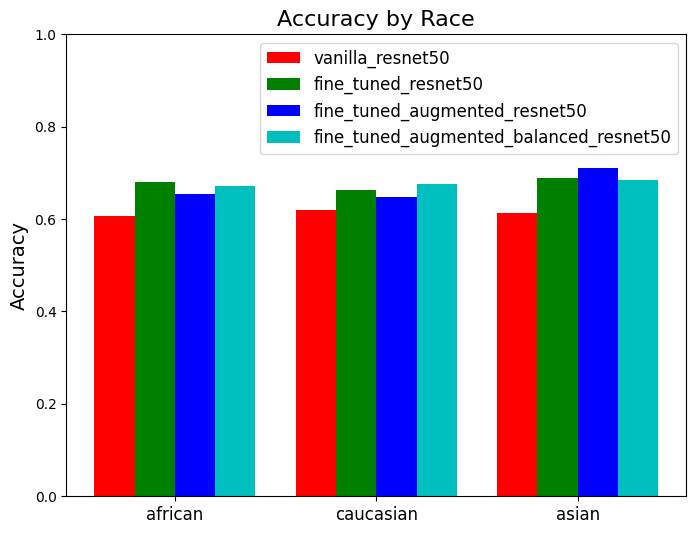

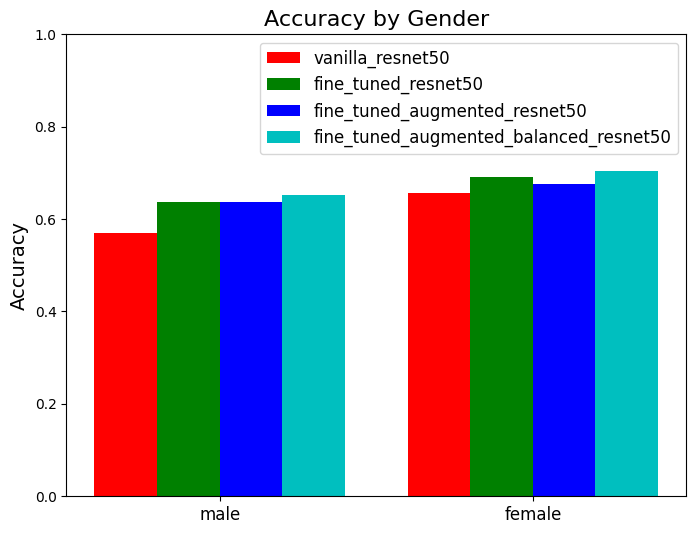

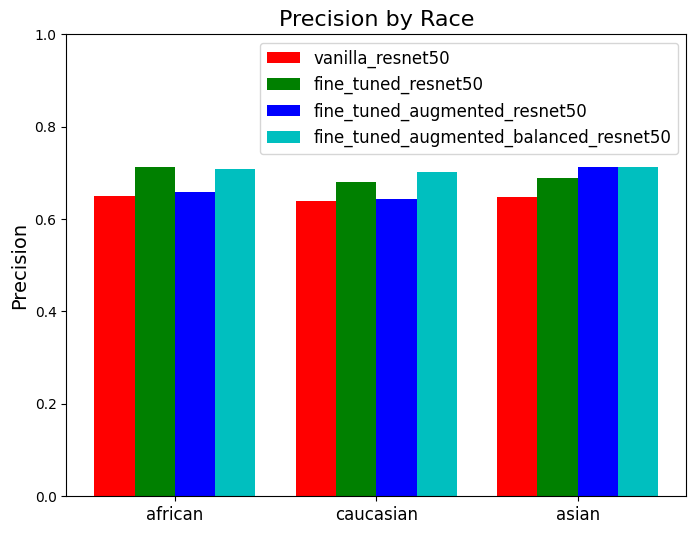

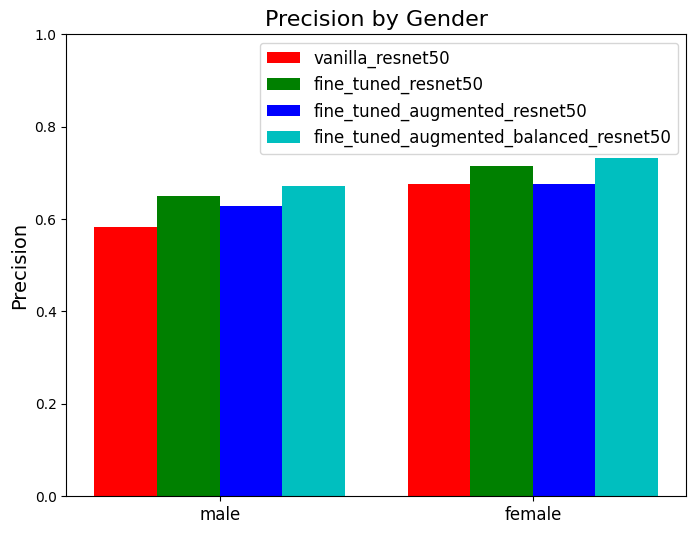

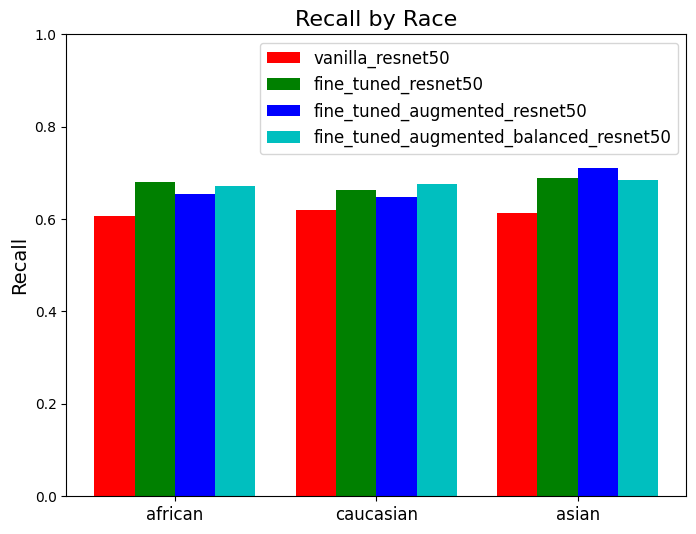

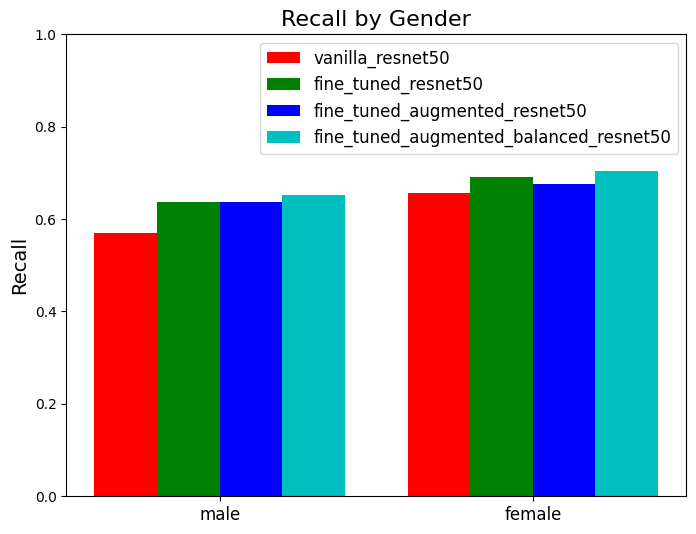

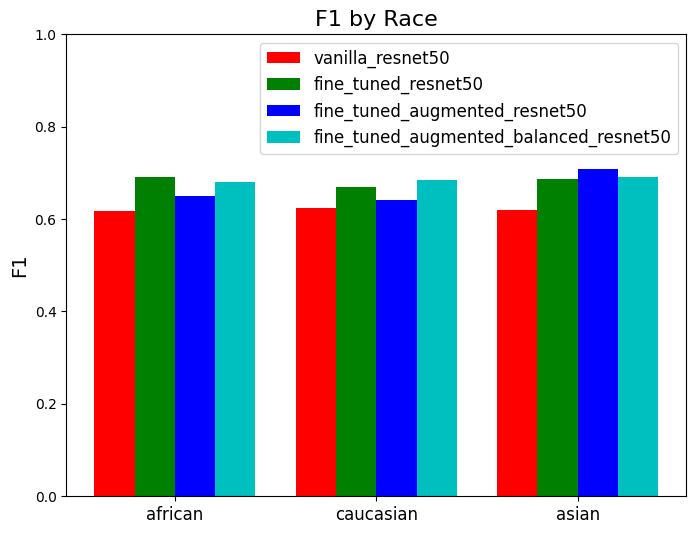

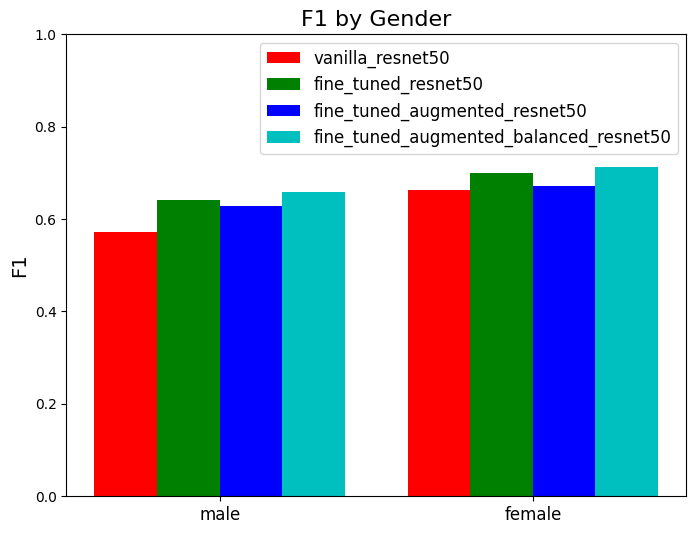

In [23]:
import numpy as np
import matplotlib.pyplot as plt

models_names = ['vanilla_resnet50', 'fine_tuned_resnet50', 'fine_tuned_augmented_resnet50', 'fine_tuned_augmented_balanced_resnet50']
metrics = ['accuracy', 'precision', 'recall', 'f1']
race_groups = ['african', 'caucasian', 'asian']
gender_groups = ['male', 'female']

colors = ['r', 'g', 'b', 'c']  # Assign colors for each model

# Calculate the total width for each group of bars
total_width = 0.8
n_models = len(models_names)
width = total_width / n_models

for metric in metrics:
    # Create separate plots for race and gender metrics
    fig_race, ax_race = plt.subplots(figsize=(8, 6))
    fig_gender, ax_gender = plt.subplots(figsize=(8, 6))
    
    # Set title and y-axis label for race plot
    ax_race.set_title(f'{metric.capitalize()} by Race', fontsize=16)
    ax_race.set_ylabel(metric.capitalize(), fontsize=14)
    ax_race.set_ylim([0, 1])
    
    # Set title and y-axis label for gender plot
    ax_gender.set_title(f'{metric.capitalize()} by Gender', fontsize=16)
    ax_gender.set_ylabel(metric.capitalize(), fontsize=14)
    ax_gender.set_ylim([0, 1])
    
    for i, model in enumerate(models_names):
        # Get race values for the current model and metric
        race_values = []
        for group in race_groups:
            if 'race' in metrics_models[model][metric] and group in metrics_models[model][metric]['race']:
                value = metrics_models[model][metric]['race'][group]
            else:
                value = 0
            race_values.append(value)
        race_color = colors[i]
        x_race = np.arange(len(race_groups)) + i * width - (total_width - width) / 2  # Calculate the x position for each bar
        ax_race.bar(x_race, race_values, width, color=race_color, label=model)
        
        # Get gender values for the current model and metric
        gender_values = []
        for group in gender_groups:
            if 'gender' in metrics_models[model][metric] and group in metrics_models[model][metric]['gender']:
                value = metrics_models[model][metric]['gender'][group]
            else:
                value = 0
            gender_values.append(value)
        gender_color = colors[i]
        x_gender = np.arange(len(gender_groups)) + i * width - (total_width - width) / 2  # Calculate the x position for each bar
        ax_gender.bar(x_gender, gender_values, width, color=gender_color, label=model)
    
    # Set x-axis labels and ticks for race plot
    ax_race.set_xticks(np.arange(len(race_groups)))
    ax_race.set_xticklabels(race_groups, fontsize=12)
    ax_race.legend(fontsize=12)
    
    # Set x-axis labels and ticks for gender plot
    ax_gender.set_xticks(np.arange(len(gender_groups)))
    ax_gender.set_xticklabels(gender_groups, fontsize=12)
    ax_gender.legend(fontsize=12)
    
    plt.show()
